In [1]:
import numpy as np
import matplotlib.pyplot as plt

from temporal_difference import SARSA, QLeaner
from envs.gridworld import GridworldEnv
from gym.envs.toy_text import CliffWalkingEnv
from utils.grid_visualization import visualize_value_function, visualize_policy

np.random.seed(0)

## SARSA와 Q-Learning

SARSA 와 Q-learning 모두 TD기법을 활용하여 최적정책을 찾는 방법이었습니다. 하지만 이 두가지 알고리즘은 각각 on-policy 와 off-policy 라는 본질적인 차이를 가지고 있었던것 기억하시나요?

> 1. on-policy 기법은 현재 평가하는 정책 $\pi(a|s)$ 와 행동 정책 $\mu(a|s)$이 동일.
> 2. off-policy 기법은 현재 평가하는 정책 $\pi(a|s)$ 와 행동 정책 $\mu(a|s)$이 다름.

즉 `Q-learning` 알고리즘은 환경으로부터 데이터를 얻기위해 사용했던 $\epsilon$-탐욕적 정책 대신, 알고리즘의 성능을 평가하기 위해서, 현재 추산된 $Q(s,a)$로 탐욕적 정책을 사용할수 있다는 것입니다. 이번 실습에서는 새로운 환경에서 `SARSA`의 정책과 `Q-learning`을 통해서 구한 $Q(s,a)$에 탐욕적 정책의 차이를 확인해볼까요?

## `GridWorld` 초기화하기

가로로 `nx` 개, 세로로 `ny` 개의 칸을 가진 `GridworldEnv`를 만듭니다!

In [15]:
nx, ny = 4, 4
env = GridworldEnv([ny, nx])

TypeError: __init__() takes 1 positional argument but 2 were given

In [3]:
sarsa_agent = SARSA(gamma=1.0,
                    lr=1e-1,
                    num_states=env.nS,
                    num_actions=env.nA,
                    epsilon=1.0)

In [4]:
qlearning_agent = QLeaner(gamma=1.0,
                          lr=1e-1,
                          num_states=env.nS,
                          num_actions=env.nA,
                          epsilon=1.0)

In [5]:
def run_sarsa(agent, env, mode='train', timeout=500):
    
    env.reset()
    reward_sum = 0
    counter = 0 
    
    while True:
        state = env.s
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_action = sarsa_agent.get_action(next_state)
        counter += 1
        
        if mode == 'train':
            agent.update_sample(state=state,
                                action=action,
                                reward=reward,
                                next_state=next_state,
                                next_action=next_action,
                                done=done)
    
        elif mode == 'eval':
            pass
        
        else:
            raise RuntimeError("mode {} is not valid".format(mode))        

        reward_sum += reward
        if done:
            break
            
        if counter >= timeout:
            break
        
    return reward_sum

def run_qlearning(agent, env, mode='train', timeout=500):
    
    env.reset()
    reward_sum = 0
    counter = 0
    
    while True:
        state = env.s
        action = agent.get_action(state, mode=mode)
        next_state, reward, done, info = env.step(action)
        counter += 1

        if mode == 'train':
            agent.update_sample(state=state,
                                action=action,
                                reward=reward,
                                next_state=next_state,
                                done=done)    
        elif mode == 'eval':
            pass
        
        else:
            raise RuntimeError("mode {} is not valid".format(mode))        

        reward_sum += reward
        if done:
            break
        
        if counter >= timeout:
            break
            
    return reward_sum

In [6]:
def get_epsilon(episode_idx, warmup_period=30):
    if episode_idx <= warmup_period:
        eps = 1.0
    else:
        eps = 1/(episode_idx - warmup_period)
    return eps

In [7]:
n_eps = 50
warmup_period = 5
num_reps = 10
ep_idx = np.arange(1,n_eps+1)
sarsa_means = []
sarsa_stds = []
qlearning_means = []
qlearning_stds = []
epsilons = []

report_every = 10

for i in ep_idx:
    if i % report_every == 0:
        print("Running {} th episode".format(i))
    eps = get_epsilon(i, warmup_period)
    sarsa_agent.epsilon = eps 
    qlearning_agent.epsilon = eps

    
    # 에이전트를 훈련합니다.
    _ = run_sarsa(sarsa_agent, env)
    _ = run_qlearning(qlearning_agent, env)
    
    
    if i > warmup_period:
        # 에이전트를 평가합니다.
        # 1. 에피소드의 시작이 매번 랜덤하게 결정되고
        # 2. SARSA의 경우는 정책함수가 추계적이기 때문에 
        # 훈련 진행상황에 따라 각 에이전트의 평균적인 성능을 평가.

        epsilons.append(eps)

        sarsa_rets = [run_sarsa(sarsa_agent, env, mode='eval') for _ in range(num_reps)]
        ql_rets = [run_qlearning(qlearning_agent, env, mode='eval') for _ in range(num_reps)]

        sarsa_rets = np.stack(sarsa_rets)
        ql_rets = np.stack(ql_rets)

        sarsa_means.append(np.mean(sarsa_rets))
        sarsa_stds.append(np.std(sarsa_rets))

        qlearning_means.append(np.mean(ql_rets))
        qlearning_stds.append(np.std(ql_rets))

sarsa_means = np.array(sarsa_means)
sarsa_stds = np.array(sarsa_stds)
qlearning_means = np.array(qlearning_means)
qlearning_stds = np.array(qlearning_stds)

Running 10 th episode
Running 20 th episode
Running 30 th episode
Running 40 th episode
Running 50 th episode


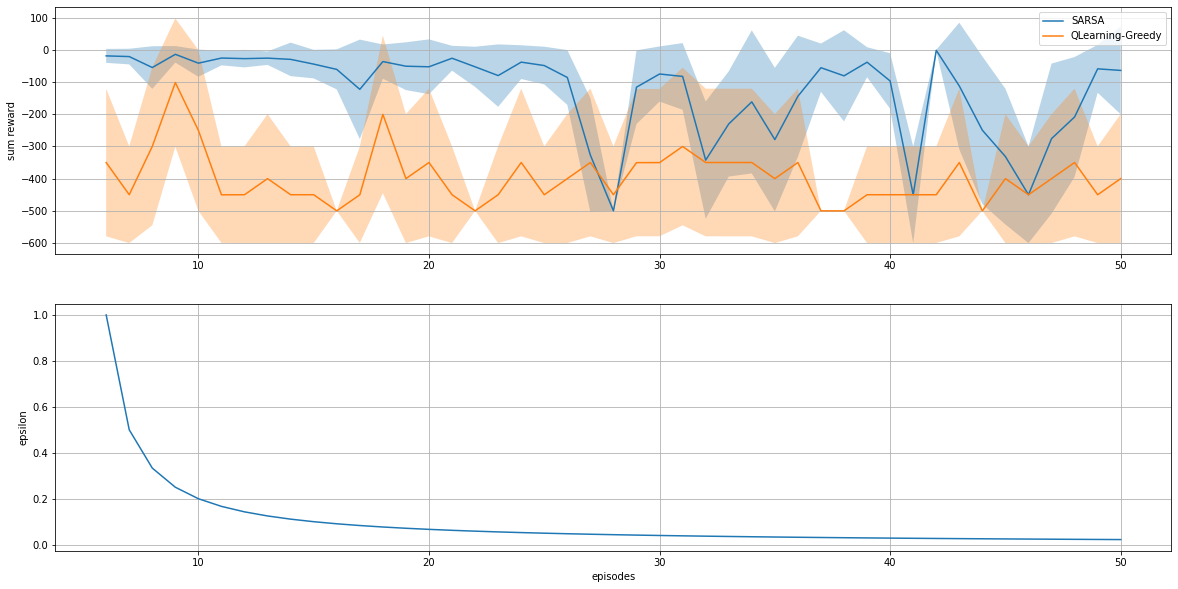

In [8]:
x_pos = ep_idx[warmup_period:]

fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].grid()
ax[0].fill_between(x=x_pos,
                   y1=sarsa_means + sarsa_stds,
                   y2=sarsa_means - sarsa_stds,
                   alpha=0.3)
ax[0].plot(x_pos, sarsa_means, label='SARSA')

ax[0].fill_between(x=x_pos,
                   y1=qlearning_means + qlearning_stds,
                   y2=qlearning_means - qlearning_stds,
                   alpha=0.3)
ax[0].plot(x_pos, qlearning_means, label='QLearning-Greedy')
ax[0].legend()
_= ax[0].set_ylabel('sum reward')

ax[1].grid()
ax[1].plot(x_pos, epsilons)
_= ax[1].set_xlabel('episodes')
_= ax[1].set_ylabel('epsilon')

In [9]:
cliff_env = CliffWalkingEnv()

In [10]:
sarsa_agent = SARSA(gamma=.9,
                    lr=1e-1,
                    num_states=cliff_env.nS,
                    num_actions=cliff_env.nA,
                    epsilon=0.1)

q_agent = QLeaner(gamma=.9,
                  lr=1e-1,
                  num_states=cliff_env.nS,
                  num_actions=cliff_env.nA,
                  epsilon=0.1)

In [11]:
num_eps = 1500
report_every = 250


sarsa_rewards = []
qlearning_rewards = []

for i in range(num_eps):
    sarsa_reward_sum = run_sarsa(sarsa_agent, cliff_env)
    qlearning_reward_sum = run_qlearning(q_agent, cliff_env)
    
    sarsa_rewards.append(sarsa_reward_sum)
    qlearning_rewards.append(qlearning_reward_sum)

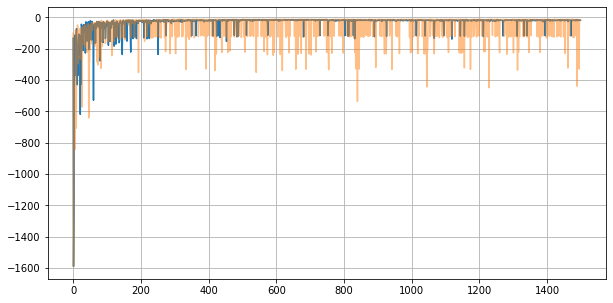

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.grid()
ax.plot(sarsa_rewards, label='SARSA episode reward')
ax.plot(qlearning_rewards, label='Q-Learing episode reward', alpha=0.5)

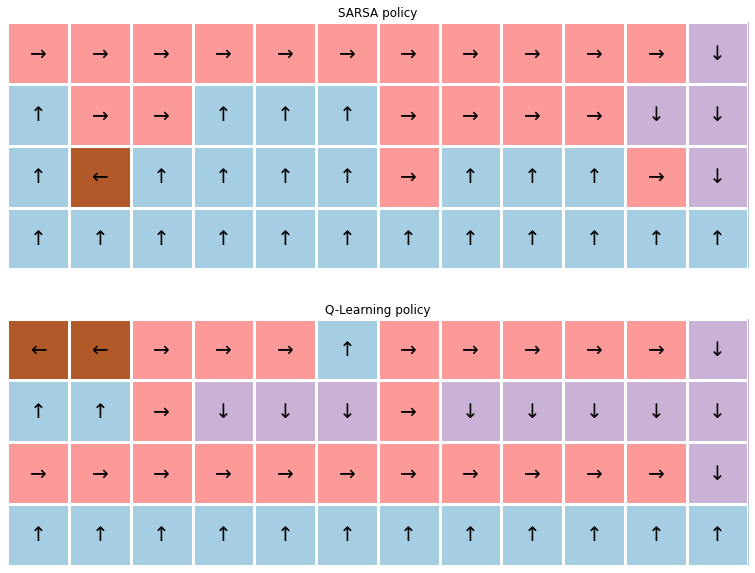

In [14]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
visualize_policy(ax[0], sarsa_agent.q, cliff_env.shape[0], cliff_env.shape[1])
_ = ax[0].set_title("SARSA policy")

visualize_policy(ax[1], q_agent.q, cliff_env.shape[0], cliff_env.shape[1])
_ = ax[1].set_title("Q-Learning policy")